<a href="https://colab.research.google.com/github/3210jr/tictactoe/blob/master/rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This connects your google drive with this notebook
# --------
# Make sure your have granted access to a shared drive called "RND", otherwise
# steps that follow will not work.

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path

# shared folder with all the resources
WORKING_DIR = Path("/content/drive/Shareddrives/RND/HERS")

DATA_DIR = Path(WORKING_DIR, 'data')

# where the output of the data from qa may go
ENVIRON_DIR = Path(DATA_DIR, "environ")

# raw data exported from athenaOne are
DATA_DUMPS_DIR = Path.joinpath(DATA_DIR, "exports-20250729")

# contains the csv version of most of the files from the {DATA_DUMPS_DIR}
CSV_DUMPS_DIR = DATA_DIR.joinpath("./csv-exports-20250729")

# csv analysis dat
CSV_ANALYSIS_DIR = Path(DATA_DIR, "../", "csv_analysis")

# open AQ api keyA
OPENQA_API_KEY=open(Path(DATA_DIR, "./secrets/openaq.apikey")).read().strip()

# # AirNow API key
# AIRNOW_API_KEY=open(Path(DATA_DIR, "./secrets/airnow.apikey")).read().strip()

# ✅
# Open weather map ally: a783a8053025020467b9c72c9618eecf
# miami rescue: 25.795592, -80.196705

In [ ]:
# range of data
!find {DATA_DUMPS_DIR}/*.ndjson

/content/drive/Shareddrives/RND/HERS/data/exports-20250729/AllergyIntolerance.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/CarePlan.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/Condition.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/DiagnosticReport.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/Encounter.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/MedicationDispense.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/Medication.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/MedicationRequest.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/Observation.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/Patient.ndjson
/content/drive/Shareddrives/RND/HERS/data/exports-20250729/ServiceRequest.ndjson


### RF / XGB

X:
- social_history.answers ...
- env_temp
- env_aqi
- patient.gender
- patient.age (from birthDate)

Y:
- temp
- respiratory_rate
- pulse_rate
- bp_systolic, bp_diatolic
- o2_saturation

---

Things to be done:
- [ ] check the distribution of the vital signs. is there a guarantee that the all 5 (see Y above) vital signs are collected for every patient, on the same "day"?
  - If not, we only use respiratory_rate and o2_saturation

In [ ]:
CSV_ANALYSIS_DIR
!find {CSV_ANALYSIS_DIR}/*.csv

/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/all_encounters_count.csv
/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/all_encounters_table.csv
/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/env_table.csv
/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/interested_conditions_table.csv
/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/interested_encounters_count.csv
/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/interested_encounters_table.csv
/content/drive/Shareddrives/RND/HERS/data/../csv_analysis/vitals_table.csv


In [ ]:
!head /content/drive/Shareddrives/RND/HERS/data/../csv_analysis/env_table.csv

time,mean_temp,mean_pm25
2016-01-01,25.2,0
2016-01-02,23.6,0
2016-01-03,22.7,0
2016-01-04,18.5,0
2016-01-05,20.4,0
2016-01-06,20.4,0
2016-01-07,20.5,0
2016-01-08,21.9,0
2016-01-09,22.4,0


In [ ]:
!curl -H "Content-Type: application/json" http://api.openweathermap.org/data/2.5/air_pollution/history?lat=25.795592&lon=-80.196705&start=1725112800&end=1725357600&appid=a783a8053025020467b9c72c9618eecf

{"cod":401, "message": "Invalid API key. Please see https://openweathermap.org/faq#error401 for more info."}

In [ ]:
# # ✅ API
# api = "http://api.openweathermap.org/data/2.5/air_pollution/history?lat=25.795592&lon=-80.196705&start=1725112800&end=1725357600&appid=bb8e43bcb70cc82d0bdb4003321a28ca"

# # get request
# import requests

# x = requests.get(api)
# x.json()

In [ ]:
# get request
import requests
from datetime import datetime

GEO_LAT = 25.795592
GEO_LON = -80.196705

EARLIER_DATE='2016-01-01'
LATEST_DATE='2025-08-27'

# start = int(datetime.fromisoformat(f'{EARLIER_DATE}T00:00:00').timestamp())
# end = int(datetime.fromisoformat(f'{LATEST_DATE}T00:00:00').timestamp())

# api = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={GEO_LAT}&lon={GEO_LON}&start={start}&end={end}&appid=bb8e43bcb70cc82d0bdb4003321a28ca"
# x = requests.get(api)
# r = x.json()

# # print(r.keys())

# try:
#   components = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
#   import csv
#   with open("env_aqi_hourly.csv", "w+") as f:
#     w = csv.writer(f)
#     w.writerow(["time", *components])
#     for v in r["list"]:
#       dt = datetime.fromtimestamp(v["dt"])
#       w.writerow([dt.isoformat(), *[v["components"][l] for l in components]])
# except:
#   print(r, start, end)

In [ ]:
!curl -G "https://archive-api.open-meteo.com/v1/archive?latitude={GEO_LAT}&longitude={GEO_LON}&start_date={EARLIER_DATE}&end_date={LATEST_DATE}&daily=temperature_2m_mean&timezone=America%2FNew_York" -s > env_temp.json
# !cat env_temp.json | jq '.daily | keys'

In [ ]:
!head {ENVIRON_DIR}/env_aqi_hourly.csv

time,co,no,no2,o3,so2,pm2_5,pm10,nh3
2020-11-25T01:00:00,210.29,0,5.36,82.97,1.86,6.16,19.45,0.19
2020-11-25T02:00:00,216.96,0,5.57,80.82,1.7,6.06,19.04,0.23
2020-11-25T03:00:00,220.3,0,5.83,79.39,1.36,5.87,18.87,0.29
2020-11-25T04:00:00,213.62,0,4.97,81.54,1.06,5.42,19.05,0.24
2020-11-25T05:00:00,203.61,0,3.09,87.26,0.98,4.92,20.42,0.1
2020-11-25T06:00:00,196.93,0,2.25,92.98,1.04,4.65,21.22,0.05
2020-11-25T07:00:00,193.6,0,1.99,95.84,1.07,4.53,21.12,0.04
2020-11-25T08:00:00,191.93,0,1.86,98.71,1.07,4.5,20.86,0.04
2020-11-25T09:00:00,191.93,0,1.8,98.71,1.06,4.63,21.03,0.03


In [ ]:
import pandas as pd
from collections import OrderedDict
from datetime import datetime

edf = pd.read_csv(f"{ENVIRON_DIR}/env_aqi_hourly.csv")

daily_scores = OrderedDict()
for i, r in edf.iterrows():
  time, *others = r
  date = datetime.fromisoformat(time).strftime("%Y-%m-%d")

  vals = daily_scores.get(date, [])
  vals.append(others)
  daily_scores[date] = vals

import numpy as np
headers = ["time", *[f"mean_{k}" for k in edf.columns[1:]]]
daily_results = []
print(headers)
for time, rows in daily_scores.items():
  daily_results.append((time, *np.average(np.array((rows)).transpose(), axis=1)))

import csv
with open(f'{ENVIRON_DIR}/env_aqi_daily.csv', 'w+') as f:
  w = csv.writer(f)
  w.writerow(headers)
  w.writerows(daily_results)

print("merged all the data..")

['time', 'mean_co', 'mean_no', 'mean_no2', 'mean_o3', 'mean_so2', 'mean_pm2_5', 'mean_pm10', 'mean_nh3']
merged all the data..


In [ ]:
import pandas as pd
import os

vitals_df = pd.read_csv(os.path.join(CSV_ANALYSIS_DIR, "vitals_table.csv"))

In [ ]:
import pandas as pd
import os

interested_encounters_df = pd.read_csv(os.path.join(CSV_ANALYSIS_DIR, "interested_encounters_table.csv"))
interested_patients = interested_encounters_df["patient_reference"].unique()

In [ ]:
!cat /content/drive/Shareddrives/RND/HERS/data/exports-20250729/Observation.ndjson \
  | jq -s '.[] | select(.category[0].coding[0].code == "vital-signs")' \
  | jq -c '.' \
  > Observation_vitalsigns.ndjson

In [ ]:
!head Observation_vitalsigns.ndjson

{"valueQuantity":{"unit":"centimeter","code":"cm","value":175.26,"system":"http://unitsofmeasure.org"},"identifier":[{"value":"a-23939.vitalamb-2340","system":"https://fhir.athena.io/sid/ah-observation"}],"category":[{"text":"Clinical observations measure the body's basic functions such as blood pressure, heart rate, respiratory rate, height, weight, body mass index, head circumference, pulse oximetry, temperature, and body surface area.","coding":[{"display":"Vital Signs","code":"vital-signs","system":"http://terminology.hl7.org/CodeSystem/observation-category"}]}],"effectiveDateTime":"2021-10-01","resourceType":"Observation","status":"final","id":"a-23939.vitalamb-2340","extension":[{"url":"https://fhir.athena.io/StructureDefinition/ah-practice","valueReference":{"reference":"Organization/a-1.Practice-23939"}},{"url":"https://fhir.athena.io/StructureDefinition/ah-chart-sharing-group","valueReference":{"reference":"Organization/a-23939.CSG-1"}}],"code":{"coding":[{"display":"Body heig

In [ ]:
import json
from datetime import datetime

R_HEART_RATE = "heart_rate"
R_BODY_TEMP = "temp"
R_O2_SATURATION = "oxygen_saturation"
R_RESP_RATE = 'respiratory_rate'


BLOOD_PRESSURE_CODE = '85354-9'
category_codes = {
    # BLOOD_PRESSURE_CODE: 'bp', # blood pressure
    '8310-5': R_BODY_TEMP, # Body temperature
    '8867-4': R_HEART_RATE, # Heart rate / Pulse rate /min
    '2708-6': R_O2_SATURATION, # Oxygen saturation
    '9279-1': R_RESP_RATE, # Respiratory rate /min
}

BO_SYSTOLIC_CODE = '8480-6'
BO_DIASTOLIC_CODE = '8462-4'

def find(fn, arr):
  for item in arr:
    if fn(item):
      return item

  return None

def parse_for_blood_pressure(r) -> dict[str, float]:
  v: list | None = r.get("component")
  if v is None:
    return None, None

  # dict(bp_systolic=systolic, bp_diastolic=diastolic)
  measurments = dict()
  val_sys = find(lambda x: x["code"]["coding"][0]["code"] == BO_SYSTOLIC_CODE, v)
  if val_sys is not None:
    q = val_sys.get("valueQuantity")
    if q is not None:
      measurments["bp_systolic"] = dict(value=q["value"], unit=q["code"])

  val_sys = find(lambda x: x["code"]["coding"][0]["code"] == BO_DIASTOLIC_CODE, v)
  if val_sys is not None:
    q = val_sys.get("valueQuantity")
    if q is not None:
      measurments["bp_diastolic"] = dict(value=q["value"], unit=q["code"])

  return measurments


# tuples are hashable
# { ([patientid: string]): { [time]: { [vitalsign]: ARRAY<values> } } }
vitals_daily_results = dict()

with open('Observation_vitalsigns.ndjson', 'r') as f:
  while True:
    try:
      r = json.loads(next(f))
      code = r["code"]["coding"][0]["code"]
      if code not in category_codes:
        continue

      dt = r["effectiveDateTime"]
      if dt is None:
        continue

      if "T" in dt:
        dt = datetime.fromisoformat(dt).strftime("%Y-%m-%d")

      patientid = r["subject"]["reference"]
      key = (patientid) # hashable

      d = vitals_daily_results.get(key, dict())
      values = d.get(dt, dict())

      if code == BLOOD_PRESSURE_CODE:
        # do blood pressure things
        v = parse_for_blood_pressure(r)
        for k in v:
          l = values.get(k, [])
          l.append(v[k])
          values[k] = l
      else:
        # do others
          q = r.get("valueQuantity")
          if q is not None:
            k = category_codes[code]
            l = values.get(k, [])
            l.append(dict(value=q["value"], unit=q["code"]))
            values[k] = l

      d[dt] = values
      vitals_daily_results[key] = d

    except (StopIteration, EOFError):
      break


In [ ]:
# using this reference: https://medlineplus.gov/ency/article/001982.htm
def critical_temp(values):
  """Calculate if critical temperature from multiple reading
  Shape:
    values := ARRAY<{ value: number, unit: string }>
  """
  for v in values:
    if v["unit"] == "[degF]":
      if v["value"] >= 100 or v["value"] < 97:
        return 1
    elif v["unit"] == "[degC]":
      if v["value"] >= 38 or v["value"] < 36.1:
        return 1
    else:
      raise Exception("unsupported unit in value" + v)

  return 0

# reference: https://www.mayoclinic.org/symptoms/hypoxemia/basics/definition/sym-20050930
def critical_o2_sat(values):
  for v in values:
    if v["unit"] == "%":
      if v["value"] <= 90:
        return 1
    else:
      raise Exception("unsupported unit in value" + v)

  return 0

# https://www.healthline.com/health/normal-respiratory-rate (12 to 20 / min) * skipping age check for now
def critical_resp_rate(values):
  for v in values:
    if v["unit"] == "/min":
      if v["value"] < 12 or v["value"] > 20:
        return 1
    else:
      raise Exception("unsupported unit in value" + v)
  return 0

# ref: https://my.clevelandclinic.org/health/diagnostics/heart-rate (60 - 100)
def critical_heart_rate(values):
  for v in values:
    if v["unit"] == "/min":
      if v["value"] > 100 or v["value"] < 60:
        return 1
    else:
      raise Exception("unsupported unit in value" + v)

  return 0

# function to check the criticality of a vital sign
ct_functions = {
    R_BODY_TEMP: critical_temp,
    R_HEART_RATE: critical_heart_rate,
    R_O2_SATURATION: critical_o2_sat,
    R_RESP_RATE: critical_resp_rate
}

# headers to match the critical readings
CRITICAL_HEADERS = [R_BODY_TEMP, R_HEART_RATE, R_O2_SATURATION, R_RESP_RATE]

# ARRAY<TUPLE[time, patient, SCORES[temp_critocal, heart_rate, o2_sat, resp_rate]]>
results = []
for p, timereading in vitals_daily_results.items():
  if p not in interested_patients:
    # filtering reading to only include those from
    # the interested patients
    continue

  for time, vitals in timereading.items():
    # using -1 to show no reading
     results.append((p, time, [ct_functions[v](vitals.get(v)) if vitals.get(v) is not None else -1 for v in CRITICAL_HEADERS]))


# see samples
results[10:20]

[('Patient/a-23939.E-23638', '2024-02-22', [1, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-02-27', [0, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-03-01', [0, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-03-13', [-1, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-03-20', [1, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-03-22', [0, 1, 0, 1]),
 ('Patient/a-23939.E-23638', '2024-03-28', [0, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-04-01', [0, 0, -1, -1]),
 ('Patient/a-23939.E-23638', '2024-04-17', [0, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-04-23', [0, 0, 0, -1])]

In [ ]:

# function to check the criticality of a vital sign
ct_functions = {
    R_BODY_TEMP: critical_temp,
    R_HEART_RATE: critical_heart_rate,
    R_O2_SATURATION: critical_o2_sat,
    R_RESP_RATE: critical_resp_rate
}

# headers to match the critical readings
CRITICAL_HEADERS = [R_BODY_TEMP, R_HEART_RATE, R_O2_SATURATION, R_RESP_RATE]

# create patient daily criticality table
tmp_results = []
for p, tvitals in vitals_daily_results.items():
  for time, vitals in tvitals.items():
     tmp_results.append((time, p, *[ct_functions[v](vitals.get(v)) if vitals.get(v) is not None else None for v in CRITICAL_HEADERS]))

import csv
with open('patient_time_vital_criticality.csv', 'w+') as f:
  w = csv.writer(f)
  w.writerow(["time", "patient_reference", *CRITICAL_HEADERS])
  w.writerows(tmp_results)

tmp_results[:10]

[('2021-10-01', 'Patient/a-23939.E-23347', 0, 0, 0, 0),
 ('2021-09-03', 'Patient/a-23939.E-23347', None, 0, 0, None),
 ('2023-05-24', 'Patient/a-23939.E-23582', 0, 0, 0, None),
 ('2023-07-31', 'Patient/a-23939.E-23582', 0, 0, 0, None),
 ('2022-03-07', 'Patient/a-23939.E-23804', 0, 0, 0, 0),
 ('2022-03-15', 'Patient/a-23939.E-23804', 0, 0, 0, None),
 ('2022-03-25', 'Patient/a-23939.E-23804', 1, 0, 0, None),
 ('2022-06-13', 'Patient/a-23939.E-23804', 0, 0, 0, None),
 ('2022-06-15', 'Patient/a-23939.E-23804', 0, 0, 0, None),
 ('2022-07-19', 'Patient/a-23939.E-23804', 0, 0, 0, None)]

### Create X input value

X:
1. (only using the onsetDateTime) social-history.questions (create list of all questions + useing code)
2. update


In [ ]:
!cat /content/drive/Shareddrives/RND/HERS/data/exports-20250729/Observation.ndjson \
  | jq -c 'select(.category[0].coding[0].code == "social-history" and ((.identifier[0].value | contains("pregnancyStatus")) | not))' \
  > Observations_social-history.ndjson
  # | jq -c '[, .subject.reference, .code.text, .valueCodeableConcept.text]'

In [ ]:
# 24009 - social-history w/o pregnancyStatus questions + w/ encounter + w/ responses
# later, we filter to only include the set from "interested" members
!cat Observations_social-history.ndjson \
  | jq -c 'select(.dataAbsentReason == null)' \
  | jq -c 'select(.encounter != null)' \
  > Observation_social-history_w_encounter.ndjson

In [ ]:
!head -1 Observation_social-history_w_encounter.ndjson \
  | jq '.'

{
  "identifier": [
    {
      "value": "a-23939.socialHistory-11457",
      "system": "https://fhir.athena.io/sid/ah-observation"
    }
  ],
  "category": [
    {
      "text": "Social History Observations define the patient's occupational, personal (e.g., lifestyle), social, familial, and environmental history and health risk factors that may impact the patient's health.",
      "coding": [
        {
          "display": "Social History",
          "code": "social-history",
          "system": "http://terminology.hl7.org/CodeSystem/observation-category"
        }
      ]
    },
    {
      "text": "Functional Status category",
      "coding": [
        {
          "display": "Functional Status",
          "code": "functional-status",
          "system": "http://hl7.org/fhir/us/core/CodeSystem/us-core-category"
        }
      ]
    }
  ],
  "encounter": {
    "type": "Encounter",
    "reference": "Encounter/a-23939.encounter-12662"
  },
  "resourceType": "Observation",
  "effectiveD

In [ ]:
import os
import json
from datetime import datetime

# Record<snowmed_string, string>
questions_code = dict()
code_answers = dict()

# I want these so as I can do analysis over them
free_input_answers = dict()

social_history_results = []

# { [patientid: string]: Array<[question, answer_type, answer_value ]>}
patient_questions_responses = dict()

with open('Observation_social-history_w_encounter.ndjson', 'r') as f:
  while True:
    try:
      o = json.loads(next(f))

      question_text = o["code"]["text"].strip().lower() # using only the first code
      for c in o["code"].get("coding", []):
        questions_code[c["code"]] = question_text

      id = f'{o["resourceType"]}/{o["id"]}'

      date = datetime.fromisoformat(o["effectiveDateTime"]).strftime("%Y-%m-%d")
      patientid = o["subject"]["reference"]

      answer = None
      answer_type = None
      if o.get("valueCodeableConcept") is not None:
        is_free_text = False
        answer = o["valueCodeableConcept"]["text"].strip().lower()
        answercoding = o["valueCodeableConcept"].get("coding")
        if answercoding is not None:
          answer_type = "_CATEGORICAL_"
          for c in answercoding:
            code_answers[c["code"]] = answer
        else:
          # we are assuming these are free text,
          # so we just include these
          free_input_answers[id] = (o["valueCodeableConcept"])
          answer_type = "_FREE_TEXT_"
          is_free_text = True
      elif o.get('valueDateTime') is not None:
        answer = o["valueDateTime"]
        answer_type = "_DATETIME_"
      else:
        print(o)
        raise Exception()


      v = patient_questions_responses.get(patientid, dict())
      v[question_text] = (answer_type, answer)
      patient_questions_responses[patientid] = v

    except (StopIteration, EOFError):
      break


In [ ]:
# 1. get all unique questions
unique_questions = set() # these are later going to be used to create a question-response matrix

# 2. use the question and get all potential answers
# { [question: string]: ({ type: '_FREE_TEXT_', sample: any[] }) | { type: _CATEGORICAL_, options: [] } | { type: _DATETIME_, sample_dates: DateString[] } }
response_buckets = dict()
for p, qa in patient_questions_responses.items():
  for q, a in qa.items():
    q = q.strip().lower()
    unique_questions.add(q)

    at, av = a
    if response_buckets.get(q) is None:
      response_buckets[q] = { "type": at }

    if at == '_FREE_TEXT_':
      # print("SHOULDN'T BE HERE", a)
      samples = response_buckets[q].get('samples')
      if samples is None:
        samples = []

      if av not in samples:
        samples.append(av)

      response_buckets[q]["type"] = at
      response_buckets[q]["samples"] = samples
    elif at == '_CATEGORICAL_':
      categs = response_buckets[q].get('options')
      if categs is None:
        categs = []

      if av not in categs:
        categs.append(av)

      # print(categs)
      # if any(map(lambda a: a in ("divorced", "married"), categs)):
      #     print(q, a)
      response_buckets[q]["type"] = at
      response_buckets[q]["options"] = categs
    elif at == '_DATETIME_':
      sample_dates = response_buckets[q].get('sample_dates', [])
      if av not in sample_dates:
        sample_dates.append(av)

      response_buckets[q]["type"] = at
      response_buckets[q]["sample_dates"] = samples

    # if a not in ax:
    #   ax.append(a)

    # response_buckets[q] = ax
response_buckets['what is your relationship status?']

{'type': '_CATEGORICAL_',
 'options': ['divorced', 'widowed', 'married', 'separated'],
 'samples': ['single', 'unknown', 'domestic partner', '2024-05-24', 'other']}

In [ ]:
import re

def yes_no(input):
  return input in ('y', 'yes')

def transform_categorical(v):
  is_yes_no = False
  for s in v["options"]:
    if s.lower() in ["y", 'n', 'yes', 'no']:
      is_yes_no = True
    else:
      is_yes_no = False
      break

  if is_yes_no:
    return { 'type': 'boolean', 'op': yes_no, }

  return { 'type': 'options',
          'normalize': lambda options, x: 'unknown' if x not in options else x,
           'options': [*sorted([l.lower() for l in v["options"]]), 'unknown'] }


def transform_free_text(v):
  """Transform sample data"""
  is_yes_no = False

  for s in v["samples"]:
    if s.lower() in ["y", 'n', 'yes', 'no']:
      is_yes_no = True
    else:
      is_yes_no = False
      break

  is_number = False
  for s in v["samples"]:
    if re.match(r'^((-)?((\d+)?\.)?)+?((\d)*)$', s):
      is_number = True
    else:
      is_number = False
      break


  if is_number:
    return { 'type': 'number', 'op': float, }

  if is_yes_no:
    return { 'type': 'boolean', 'op': yes_no, }

  # # when samples options are less than 6, assume they are options to pick from
  # if len(v["samples"]) <= 5:
  #   return { 'type': 'options', 'options': v["samples"]}

  return { 'type': 'free_text', 't': v["samples"] }

def transform_datetime(v):
  return { 'type': 'datetime' }

answer_transform = {
    '_CATEGORICAL_': transform_categorical,
    '_FREE_TEXT_': transform_free_text,
    '_DATETIME_': transform_datetime,
}

specific_question_transform = {
    'was your marijuana use recreational or medical?': lambda x: { 'type': 'options', 'options': ['recreational', 'medical'], },
    'what is your relationship status?': lambda x: { 'type': 'options',
                                                    'normalize': lambda options, x: 'other' if x not in options else x,
                                                     'options': ([*x["options"], 'other']), },
    'how much tobacco do you smoke?': lambda x: { 'type': 'options',
                                                 'normalize': lambda options, x: 'other' if x not in options else x,
                                                  'options': (['none', *x["options"], 'other']), }
}

transform_response_buckets = dict()
for q, a in response_buckets.items():
    trfunc = answer_transform.get(a["type"])
    output = None
    if trfunc is not None:
      output = trfunc(a)
    else:
      output = a


    r = specific_question_transform.get(q)


    if r is not None:
      output = r(a)

    transform_response_buckets[q] = output

# remove questions with type == free_text
keys_to_remove = []
for k, v in transform_response_buckets.items():
  if v["type"] == 'free_text':
    keys_to_remove.append(k)

# remove then
for k in keys_to_remove:
  del transform_response_buckets[k]

transform_response_buckets['how much tobacco do you smoke?']

{'type': 'options',
 'normalize': <function __main__.<lambda>.<locals>.<lambda>(options, x)>,
 'options': ['none',
  '1 pack per day',
  '1/2 pack per day',
  '1 pack per week',
  '1/4 pack per day',
  '2 packs per day',
  '2 packs per week',
  '3 or more packs per day',
  'other']}

In [ ]:
import csv
with open("questions.csv", 'w+') as f:
  w = csv.writer(f)
  w.writerow(["question", "type", "options", "samples"])
  for q, p in transform_response_buckets.items():
    w.writerow([q, p["type"], p.get("options"), p.get("samples")])

# transform_response_buckets['how much tobacco do you smoke?']

In [ ]:
!head questions.csv

question,type,options,samples
how many times per week do you consume alcohol?,options,"['1-2 times per week', '3-4 times per week', '5-7 times per week', 'less than 1 time per week', 'unknown']",
have you ever been counseled for unhealthy alcohol use?,boolean,,
are you sexually active?,boolean,,
what is your relationship status?,options,"['divorced', 'widowed', 'married', 'separated', 'other']",
do you use protection during sex?,options,"['always', 'no', 'usually', 'unknown']",
do you use any illicit or recreational drugs?,boolean,,
what is the highest grade or level of school you have completed or the highest degree you have received?,options,"['10th grade', '11th grade', '12th grade, no diploma', '6th grade', '7th grade', '8th grade', '9th grade', 'associate degree: academic program', 'associate degree: occupational, technical, or vocational program', ""bachelor's degree (e.g., ba, ab, bs)"", 'ged or equivalent', 'high school graduate', ""master's degree (e.g., ma, ms, meng, med, msw

In [ ]:
!cp questions.csv {DATA_DIR}/questions.csv

In [ ]:
# boolean is LE (binary)
# numbers are number
# options are OHE

# patient => [... questions_answers ....]
social_history_results= dict()

for p, qas in patient_questions_responses.items():
  answer_row = social_history_results.get(p, dict())
  for q, a in qas.items():
    try:
      answertype, answer = a

      # used in transforming the answer
      resp_obj = transform_response_buckets.get(q)
      if resp_obj is None:
        # if a question was a free_text type, it was probably ignored
        continue


      if resp_obj["type"] == "options":
        normalizefn = resp_obj.get("normalize")
        if normalizefn is not None:
          answer = normalizefn(resp_obj["options"], answer)

        # label encoding using index
        ix = resp_obj["options"].index(answer)
        answer_row[q] = ix + 1

      if resp_obj["type"] in ("number", "boolean"):
        answer_row[q] = resp_obj["op"](answer)

    except Exception as err:
      print(q,resp_obj)
      raise err


  social_history_results[p] = answer_row

In [ ]:
list(social_history_results.items())[:4]

[('Patient/a-23939.E-23582',
  {'how many times per week do you consume alcohol?': 4}),
 ('Patient/a-23939.E-23804',
  {'have you ever been counseled for unhealthy alcohol use?': True,
   'are you sexually active?': True,
   'what is your relationship status?': 1,
   'do you use protection during sex?': 2}),
 ('Patient/a-23939.E-23694',
  {'do you use any illicit or recreational drugs?': False}),
 ('Patient/a-23939.E-23638',
  {'do you use any illicit or recreational drugs?': False,
   'what is the highest grade or level of school you have completed or the highest degree you have received?': 8,
   'are you currently in school?': False,
   'how much tobacco do you smoke?': 1,
   'how many times in the past year have you used an illegal drug or used a prescription medication for nonmedical reasons?': 0.0})]

In [ ]:
# ready to LE and OHE values
min(results, key=lambda x: x[1])

('Patient/a-23939.E-12560', '2016-02-24', [0, 0, -1, -1])

## Crossing the X-es with the Y-es

In [ ]:
import pandas as pd
import os

env_df = pd.read_csv(os.path.join(CSV_ANALYSIS_DIR, "env_table.csv"))
env_df = env_df.set_index("time")
env_df.loc["2016-01-01", "mean_temp"]

np.float64(25.2)

In [ ]:
results[:3]

[('Patient/a-23939.E-23638', '2025-07-28', [1, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2023-12-27', [0, 0, 0, -1]),
 ('Patient/a-23939.E-23638', '2024-01-03', [0, 0, 0, 0])]

In [ ]:
import numpy as np
from datetime import datetime

## all questions and the OHE / LE responses
QUESTIONS = sorted(list(transform_response_buckets.keys()))

xyresults = []
for p, time, ys in results:
  # 1 if there's at least 1 critical reading, 0 otherwise
  Y = 1 if max(ys) == 1 else 0

  qx = social_history_results.get(p)
  if qx is None:
    continue

  # for the X values
  # should be: env_mean_temp, questions
  X = [datetime.strptime(time, "%Y-%m-%d"), env_df.loc[time, "mean_temp"], *[qx.get(q) if qx.get(q) is not None else np.nan for q in QUESTIONS]]

  xyresults.append((*X, Y))

# values
# max(xyresults, key=lambda l: len([ll for ll in l[0][2:] if ll is not None]))

In [ ]:
dmodel_df = pd.DataFrame(
    data=xyresults,
    columns=["time", "mean_temp", *QUESTIONS, "critical_score"]
)


!mkdir -p {DATA_DIR}/model_ready_data

# setting the `options` type as categorical
for q, v in transform_response_buckets.items():
  if v["type"] == "options":
    dmodel_df[q] = dmodel_df[q].astype("category")


dmodel_df.to_csv(os.path.join(DATA_DIR, "model_ready_data/interested_critical_data.csv"), index=False)

## Drawing correlations

In [ ]:
import numpy as np

reduce_fn = np.max

# using this reference: https://medlineplus.gov/ency/article/001982.htm
def critical_temp(values):
  """Calculate if critical temperature from multiple reading
  Shape:
    values := ARRAY<{ value: number, unit: string }>
  """
  acx = []
  for v in values:
    if v["unit"] == "[degF]":
      acx.append(v["value"])
    elif v["unit"] == "[degC]":
      acx.append((v["value"] * 9/5) + 32)
    else:
      raise Exception("unsupported unit in value" + v)

  return reduce_fn(acx)

# reference: https://www.mayoclinic.org/symptoms/hypoxemia/basics/definition/sym-20050930
def critical_o2_sat(values):
  acx = []
  for v in values:
    if v["unit"] == "%":
      acx.append(v["value"])
    else:
      raise Exception("unsupported unit in value" + v)

  return reduce_fn(acx)

# https://www.healthline.com/health/normal-respiratory-rate (12 to 20 / min) * skipping age check for now
def critical_resp_rate(values):
  acx = []
  for v in values:
    if v["unit"] == "/min":
      acx.append(v["value"])
    else:
      raise Exception("unsupported unit in value" + v)
  return reduce_fn(acx)

# ref: https://my.clevelandclinic.org/health/diagnostics/heart-rate (60 - 100)
def critical_heart_rate(values):
  acx = []
  for v in values:
    if v["unit"] == "/min":
      acx.append(v["value"])
    else:
      raise Exception("unsupported unit in value" + v)

  return reduce_fn(acx)

# function to check the criticality of a vital sign
ct_functions = {
    R_BODY_TEMP: critical_temp,
    R_HEART_RATE: critical_heart_rate,
    R_O2_SATURATION: critical_o2_sat,
    R_RESP_RATE: critical_resp_rate
}

# headers to match the critical readings
CRITICAL_HEADERS = [R_BODY_TEMP, R_HEART_RATE, R_O2_SATURATION, R_RESP_RATE]

# ARRAY<TUPLE[time, patient, SCORES[temp_critocal, heart_rate, o2_sat, resp_rate]]>
abc = []
for p, timereading in vitals_daily_results.items():
  if p not in interested_patients:
    # filtering reading to only include those from
    # the interested patients
    continue

  for time, vitals in timereading.items():
    # using -1 to show no reading
     abc.append((p, time, *[ct_functions[v](vitals.get(v)) if vitals.get(v) is not None else None for v in CRITICAL_HEADERS]))

import csv
with open("patients_max.csv", "w") as f:
  w = csv.writer(f)
  w.writerow(["patient", "time", *CRITICAL_HEADERS])
  w.writerows(abc)

# see samples
abc[:3]

[('Patient/a-23939.E-23638',
  '2025-07-28',
  np.float64(96.2),
  np.int64(81),
  np.int64(98),
  None),
 ('Patient/a-23939.E-23638',
  '2023-12-27',
  np.float64(99.3),
  np.int64(71),
  np.int64(97),
  None),
 ('Patient/a-23939.E-23638',
  '2024-01-03',
  np.float64(98.1),
  np.int64(81),
  np.int64(99),
  np.int64(16))]

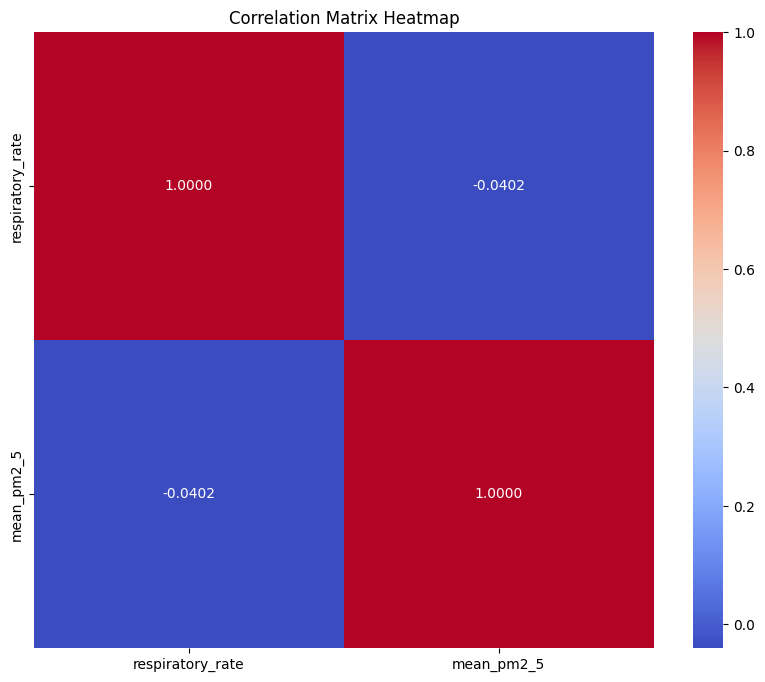

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

avgdf = pd.read_csv("patients_max.csv")
env_df = pd.read_csv(os.path.join(ENVIRON_DIR, "env_aqi_daily.csv"))

valdf = avgdf.merge(env_df, how='inner', on='time').loc[:, ["respiratory_rate", "mean_pm2_5"]]
valdf = valdf[valdf["respiratory_rate"].notna()]
valdf = valdf[valdf["mean_pm2_5"].notna()]

correlation_matrix = valdf.corr()
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Matrix Heatmap')
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/groupby/ops.py:919: RuntimeWarning: All-NaN axis encountered
  res = f(group)


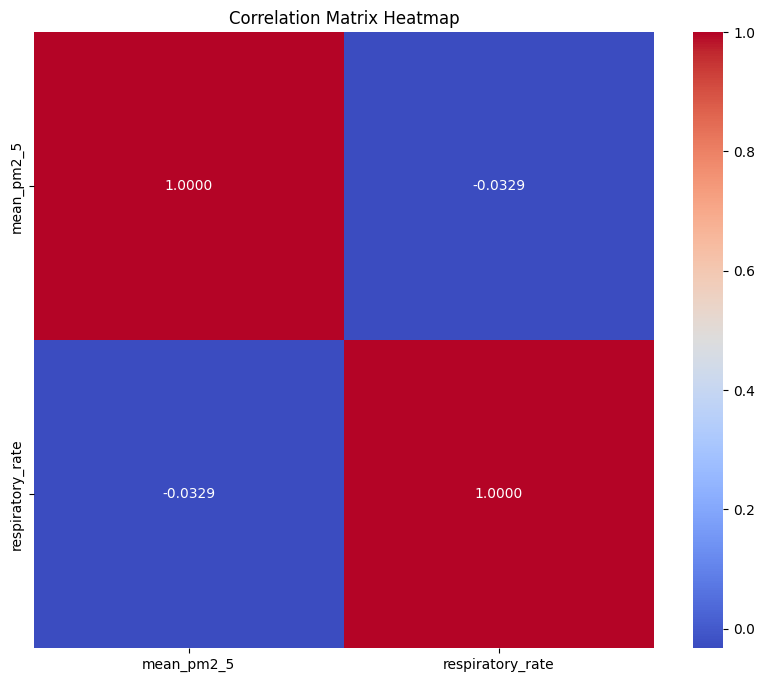

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

maxdf = pd.read_csv("patients_max.csv")
env_df = pd.read_csv(os.path.join(ENVIRON_DIR, "env_aqi_daily.csv"))

# valdf = env_df.merge(maxdf.groupby("time")["respiratory_rate"].apply(np.nanmax), how='inner', on='time').loc[:, ["respiratory_rate", "mean_pm2_5"]]
valdf = env_df.merge(maxdf.groupby("time")["respiratory_rate"].apply(np.nanmax), how='inner', on='time').loc[:, ["mean_pm2_5", "respiratory_rate"]]
valdf = valdf[valdf["respiratory_rate"].notna()]
valdf = valdf[valdf["mean_pm2_5"].notna()]
valdf

correlation_matrix = valdf.corr()
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
def max_func(r):
  return(np.nanmax(r.iloc[:].to_list()))

l = maxdf.groupby("time", group_keys=True)["respiratory_rate"].apply(max_func)
l[l.notna()]

/tmp/ipython-input-1434506957.py:2: RuntimeWarning: All-NaN axis encountered
  return(np.nanmax(r.iloc[:].to_list()))


,respiratory_rate
time,
2021-09-02,17.0
2021-09-10,16.0
2021-09-13,18.0
2021-09-15,18.0
2021-09-17,18.0
...,...
2025-06-02,14.0
2025-06-09,16.0
2025-06-16,18.0


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

grangercausalitytests(valdf, 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1843  , p=0.2775  , df_denom=253, df_num=1
ssr based chi2 test:   chi2=1.1983  , p=0.2737  , df=1
likelihood ratio test: chi2=1.1955  , p=0.2742  , df=1
parameter F test:         F=1.1843  , p=0.2775  , df_denom=253, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7251  , p=0.4853  , df_denom=250, df_num=2
ssr based chi2 test:   chi2=1.4791  , p=0.4773  , df=2
likelihood ratio test: chi2=1.4749  , p=0.4783  , df=2
parameter F test:         F=0.7251  , p=0.4853  , df_denom=250, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5622  , p=0.6405  , df_denom=247, df_num=3
ssr based chi2 test:   chi2=1.7343  , p=0.6293  , df=3
likelihood ratio test: chi2=1.7284  , p=0.6306  , df=3
parameter F test:         F=0.5622  , p=0.6405  , df_denom=247, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4578  , p=0.7667  

{np.int64(1): ({'ssr_ftest': (np.float64(1.1842811280966599),
    np.float64(0.2775217373999637),
    np.float64(253.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.1983239873231024),
    np.float64(0.27365691670779446),
    np.int64(1)),
   'lrtest': (np.float64(1.1955280598215268),
    np.float64(0.27421731048215947),
    np.int64(1)),
   'params_ftest': (np.float64(1.1842811280967118),
    np.float64(0.2775217373999558),
    np.float64(253.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.7250710684315627),
    np.float64(0.48530571177847126),
    np.float64(250.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.479144979600388),
    np.float64(0.4773179301924583),
    np.int64(2)),
   'lrtest': (np.float64(1.474871556237531),
    np.float64(0.4783389113724187),
    np.int64(2)),
   'params_ftest': (np.float64(0.7250710684315337),
    np.float64(0.4853057117784848),
    np.float64(250.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
     

## Preparing Data for v2 modeling

In [ ]:
import pandas as pd

# daily
daily_env_df = pd.read_csv(f'{ENVIRON_DIR}/env_aqi_daily.csv')
daily_env_df["time"] = pd.to_datetime(daily_env_df["time"])

daily_temp_df = pd.read_csv(f'{CSV_ANALYSIS_DIR}/env_table.csv')
daily_temp_df["time"] = pd.to_datetime(daily_temp_df["time"])

# criticality values
critical_values_df = pd.read_csv('patient_time_vital_criticality.csv')
critical_values_df["time"] = pd.to_datetime(critical_values_df["time"])

In [ ]:
from datetime import datetime, timedelta
# performing -3 days averaging of the values, NaN if missing
def mean_days_prop(prop_name, df, n=None):
  if n is None:
    n = 3 # using 3 days

  assert n > 0, "days must be a positive number greater than zero"

  def compute_windowed_average(row):
    vals = [row.get(prop_name)]
    for l in range(1, n + 1):
      d = row["time"] - timedelta(days=l)
      if str(d.date()) in df.index:
        val = df.loc[str(d.date()), prop_name]
        if not np.isnan(val):
          vals.append(val)

    vals = np.array(vals)
    return np.average(vals)

  return compute_windowed_average

In [ ]:
# calculate 3-day averages for all columns
columns_to_3d_calc = ['mean_co', 'mean_no', 'mean_no2', 'mean_o3', 'mean_so2',
       'mean_pm2_5', 'mean_pm10', 'mean_nh3']

time_index_df = daily_env_df.set_index("time")
for col in columns_to_3d_calc:
  daily_env_df[f"3_day_{col}"] = daily_env_df.apply(mean_days_prop(col, time_index_df), axis=1)

daily_temp_df["3_day_mean_temp"] = daily_temp_df.apply(mean_days_prop("mean_temp", daily_temp_df.set_index("time")), axis=1)



In [ ]:
env_3_days_df = daily_env_df.loc[:, daily_env_df.apply(lambda r: r.name == 'time' or r.name.startswith('3_day_'), axis=0)]
env_3_days_df

for col in daily_env_df.loc[:, daily_env_df.apply(lambda r: r.name.startswith('3_day_'), axis=0)].columns.to_list():
  del daily_env_df[col]

temp_3_days_df = daily_temp_df.loc[:, ["time", "3_day_mean_temp"]]
del daily_temp_df['3_day_mean_temp']

In [ ]:
# get the X dataframe
all_3_days_df = pd.merge(env_3_days_df, temp_3_days_df, on='time', how='left')
all_3_days_df

,time,3_day_mean_co,3_day_mean_no,3_day_mean_no2,3_day_mean_o3,3_day_mean_so2,3_day_mean_pm2_5,3_day_mean_pm10,3_day_mean_nh3,3_day_mean_temp
0,2020-11-25,198.894348,0.055652,3.373913,95.596087,1.167826,5.020870,21.552609,0.130435,23.675
1,2020-11-26,200.905091,0.095118,4.086123,97.301168,1.117663,4.788143,21.055679,0.183967,23.800
2,2020-11-27,236.784505,1.328967,11.101999,83.140918,1.304831,5.463484,20.123508,0.576534,23.975
3,2020-11-28,269.240566,3.136934,15.795249,74.302668,1.626227,6.295947,19.727631,0.843859,23.925
4,2020-11-29,309.465521,5.283437,21.096250,59.515937,1.785312,7.044688,18.191667,1.132604,23.600
...,...,...,...,...,...,...,...,...,...,...
1724,2025-08-23,105.860104,0.032604,0.776146,72.874792,1.172083,5.704792,7.719062,0.018542,28.550
1725,2025-08-24,100.805937,0.032604,0.763542,66.047083,1.221458,5.962396,7.777500,0.000000,28.075
1726,2025-08-25,98.680521,0.031562,0.741146,58.972813,1.067604,5.489271,7.138229,0.000000,27.625
1727,2025-08-26,97.594375,0.032187,0.678750,53.365313,0.699063,3.993542,5.588750,0.000000,27.400


## RF-Modeling: Environment vs Vitals

In [ ]:
# Extracting the values to include -3 days window for t
# Input:
# > AQI features (-3 ctx window | average)
# > Mean_temp (-3 ctx window | average)

# Output:
# > Criticality - Vitals - Split

### Modeling for all!

In [ ]:
# imputing with zero for missing recording
data_df = pd.merge(all_3_days_df, critical_values_df.fillna(0), on='time', how='right')
del data_df["patient_reference"]
del data_df["time"]

data_df

,3_day_mean_co,3_day_mean_no,3_day_mean_no2,3_day_mean_o3,3_day_mean_so2,3_day_mean_pm2_5,3_day_mean_pm10,3_day_mean_nh3,3_day_mean_temp,temp,heart_rate,oxygen_saturation,respiratory_rate
0,304.024375,1.000312,11.404479,75.691979,1.513750,5.881667,10.618854,0.378854,26.225,0.0,0.0,0.0,0.0
1,357.117292,11.314688,22.495313,27.877917,3.100208,7.617604,10.662708,1.068646,26.950,0.0,0.0,0.0,0.0
2,295.592292,3.612396,18.847917,36.207708,2.348021,4.822813,8.540833,0.624375,25.650,0.0,0.0,0.0,0.0
3,197.142500,0.917292,7.839062,43.346146,1.755521,3.812708,6.803437,0.144792,28.275,0.0,0.0,0.0,0.0
4,236.500313,0.095833,2.999479,85.629271,0.845521,4.362813,18.416250,0.134167,24.400,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14329,210.354792,0.380625,7.794896,70.817396,1.421771,4.931667,10.794375,0.252187,25.900,0.0,0.0,0.0,0.0
14330,234.433125,0.264062,6.680000,62.871250,1.507708,5.726667,11.377187,0.299687,25.125,0.0,0.0,0.0,0.0
14331,232.676354,0.607083,10.204063,74.502708,1.556667,5.925000,20.486771,0.386250,23.650,0.0,0.0,0.0,0.0
14332,238.117917,2.996354,10.483542,50.780312,1.086458,5.656979,15.812396,0.475104,24.125,0.0,0.0,0.0,0.0


In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint

y_columns = ['temp','heart_rate', 'oxygen_saturation', 'respiratory_rate']
X = data_df.drop(y_columns, axis=1)
y = data_df[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

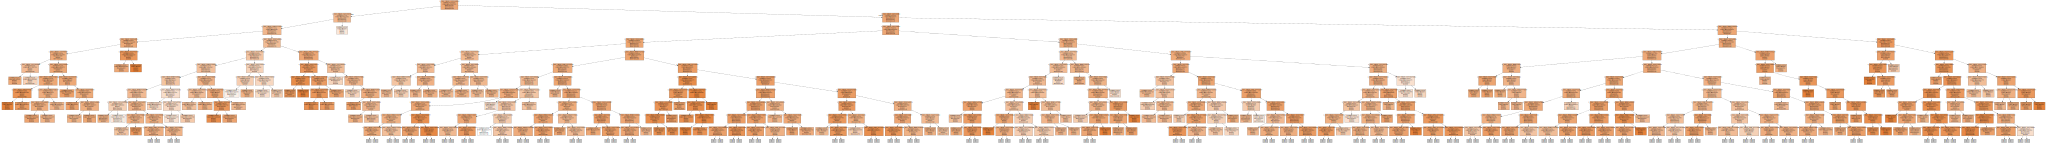

'envvs_vitals_rf_v1_model.png'

In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

tree = rf.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=X.columns,
                            filled=True,
                            max_depth=10,
                            impurity=False,
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)
graph.render(f'envvs_vitals_rf_v1_model', format='png')


In [8]:
!pip install nbconvert[webpdf]
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 60.7 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:9 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,274 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 ht

In [ ]:
!jupyter nbconvert --to webpdf --allow-errors /content/drive/MyDrive/Colab\ Notebooks/HERS-mrmc0.ipynb

In [10]:
!playwright install

173.7 MiB [] 0% 0.0s173.7 MiB [] 0% 33.3s173.7 MiB [] 0% 14.3s173.7 MiB [] 0% 5.9s173.7 MiB [] 1% 3.8s173.7 MiB [] 3% 2.5s173.7 MiB [] 4% 2.1s173.7 MiB [] 5% 2.0s173.7 MiB [] 7% 1.8s173.7 MiB [] 8% 1.6s173.7 MiB [] 10% 1.5s173.7 MiB [] 12% 1.3s173.7 MiB [] 14% 1.2s173.7 MiB [] 16% 1.1s173.7 MiB [] 18% 1.0s173.7 MiB [] 20% 1.0s173.7 MiB [] 22% 0.9s173.7 MiB [] 24% 0.8s173.7 MiB [] 26% 0.8s173.7 MiB [] 29% 0.8s173.7 MiB [] 31% 0.7s173.7 MiB [] 33% 0.7s173.7 MiB [] 35% 0.6s173.7 MiB [] 38% 0.6s173.7 MiB [] 40% 0.6s173.7 MiB [] 42% 0.5s173.7 MiB [] 44% 0.5s173.7 MiB [] 47% 0.5s173.7 MiB [] 49% 0.5s173.7 MiB [] 52% 0.4s173.7 MiB [] 54% 0.4s173.7 MiB [] 56% 0.4s173.7 MiB [] 58% 0.4s173.7 MiB [] 61% 0.3s173.7 MiB [] 63% 0.3s173.7 MiB [] 66% 0.3s173.7 MiB [] 68% 0.3s173.7 MiB [] 70% 0.2s173.7 MiB [] 73% 0.2s173.7 MiB [] 75% 0.2s173.7 MiB [] 77% 0.2s173.7 MiB [] 80% 0.2s173.7 MiB [] 82% 0.1s173.7 MiB [] 85% 0.1s173.7 MiB [] 87% 0.1s173.7 MiB [] 89% 0.1s173.7 MiB [] 92% 0.1s173.7 MiB [] 94% 0.0s

In [9]:
!jupyter nbconvert --to webpdf --allow-errors /content/drive/MyDrive/Colab\ Notebooks/HERS-mrmc0.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/HERS-mrmc0.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/exporters/webpdf.py", line 94, in main
    browser = await chromium.launch(
              ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/playwright/async_api/_generated.py", line 14465, in launch
    await self._impl_obj.launch(
  File "/usr/local/lib/python3.12/dist-packages/playwright/_impl/_browser_type.py", line 98, in launch
    await self._channel.send(
  File "/usr/local/lib/python3.12/dist-packages/playwright/_impl/_connection.py", line 69, in send
    return await self._connection.wrap_api_call(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/playwright/_impl/_connection.py", line 558, in wrap_api_call
    raise rewrite_

### Feature Importance / all

In [ ]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.8161841646320195


In [ ]:
from sklearn.metrics import classification_report
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

feature_importance = rf.feature_importances_
top_features = np.argsort(feature_importance)[-6:][::-1]
print(f"Top 10 most important features: {top_features}")
print(f"importance scores: {feature_importance[top_features]}")



Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.01      0.02       190
           1       0.00      0.00      0.00       318
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        43

   micro avg       0.14      0.00      0.01       567
   macro avg       0.07      0.00      0.01       567
weighted avg       0.10      0.00      0.01       567
 samples avg       0.00      0.00      0.00       567

Top 10 most important features: [3 1 0 4 8 2]
importance scores: [0.11884303 0.11664718 0.115904   0.1148252  0.11296823 0.10668363]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
# important features ✅
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature 3_day_mean_o3 (0.11884303474009245)
2. feature 3_day_mean_no (0.11664717776354123)
3. feature 3_day_mean_co (0.11590400213442625)
4. feature 3_day_mean_so2 (0.1148252031347543)
5. feature 3_day_mean_temp (0.11296823400553517)
6. feature 3_day_mean_no2 (0.10668363428342849)
7. feature 3_day_mean_pm2_5 (0.10655820528815654)
8. feature 3_day_mean_nh3 (0.10496573193205598)
9. feature 3_day_mean_pm10 (0.10260477671800956)


### Modeling for interested patients (Asthma, COPD, CVD)

In [ ]:
interested_patients[:3]

array(['Patient/a-23939.E-23638', 'Patient/a-23939.E-23916',
       'Patient/a-23939.E-24324'], dtype=object)

In [ ]:
# imputing with zero for missing recording
data_v2_df = pd.merge(all_3_days_df, critical_values_df.fillna(0), on='time', how='right')
data_v2_df = data_v2_df[data_v2_df["patient_reference"].isin(interested_patients)]

del data_v2_df["patient_reference"]
del data_v2_df["time"]

data_v2_df

,3_day_mean_co,3_day_mean_no,3_day_mean_no2,3_day_mean_o3,3_day_mean_so2,3_day_mean_pm2_5,3_day_mean_pm10,3_day_mean_nh3,3_day_mean_temp,temp,heart_rate,oxygen_saturation,respiratory_rate
107,91.343229,0.030312,0.442292,49.218333,0.469479,3.343229,13.731771,0.000000,29.725,1.0,0.0,0.0,0.0
108,261.953438,0.975937,9.089375,63.148958,1.342812,2.746354,5.520625,0.508646,22.100,0.0,0.0,0.0,0.0
109,426.168021,7.705521,33.021979,35.367917,2.658854,11.609375,18.794167,1.865729,15.900,0.0,0.0,0.0,0.0
110,248.914687,0.143854,8.576771,56.577604,1.391563,4.627083,10.785208,0.295208,23.100,0.0,0.0,0.0,0.0
111,259.171250,0.320521,10.681771,53.262396,1.642604,3.799271,8.900313,0.390833,22.275,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14288,349.215537,4.441316,26.896558,42.312089,2.801467,12.393955,18.034058,0.994396,21.875,0.0,0.0,0.0,0.0
14289,234.241354,2.966562,9.426250,51.685521,1.073229,5.002917,14.859896,0.444479,24.150,0.0,0.0,0.0,0.0
14290,247.679375,0.769271,10.459479,57.438958,1.937813,6.111042,13.055521,0.381667,23.650,0.0,0.0,0.0,0.0
14291,324.537604,2.451875,15.786146,70.676354,2.462187,9.768229,12.758333,0.605104,25.275,0.0,0.0,0.0,0.0


In [ ]:
y_columns = ['temp','heart_rate', 'oxygen_saturation', 'respiratory_rate']
X = data_v2_df.drop(y_columns, axis=1)
y = data_v2_df[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfv2 = RandomForestClassifier()
rfv2.fit(X_train, y_train)

RandomForestClassifier()

### Feature Importance / interested group

In [ ]:
from sklearn.metrics import classification_report
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

feature_importance = rfv2.feature_importances_
top_features = np.argsort(feature_importance)[-6:][::-1]
print(f"Top 10 most important features: {top_features}")
print(f"importance scores: {feature_importance[top_features]}")



Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.03      0.05        34
           1       0.17      0.06      0.09        67
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7

   micro avg       0.13      0.04      0.06       117
   macro avg       0.07      0.02      0.03       117
weighted avg       0.13      0.04      0.06       117
 samples avg       0.01      0.01      0.01       117

Top 10 most important features: [3 1 0 5 8 6]
importance scores: [0.1267976  0.11267131 0.11265523 0.10969338 0.10923733 0.10923099]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# important features ✅
importances = rfv2.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature 3_day_mean_o3 (0.12679760149727345)
2. feature 3_day_mean_no (0.11267131008319808)
3. feature 3_day_mean_co (0.11265522904795411)
4. feature 3_day_mean_pm2_5 (0.10969337510889283)
5. feature 3_day_mean_temp (0.10923732922592938)
6. feature 3_day_mean_pm10 (0.1092309918672803)
7. feature 3_day_mean_nh3 (0.10724803473261206)
8. feature 3_day_mean_so2 (0.10723047412776353)
9. feature 3_day_mean_no2 (0.10523565430909615)


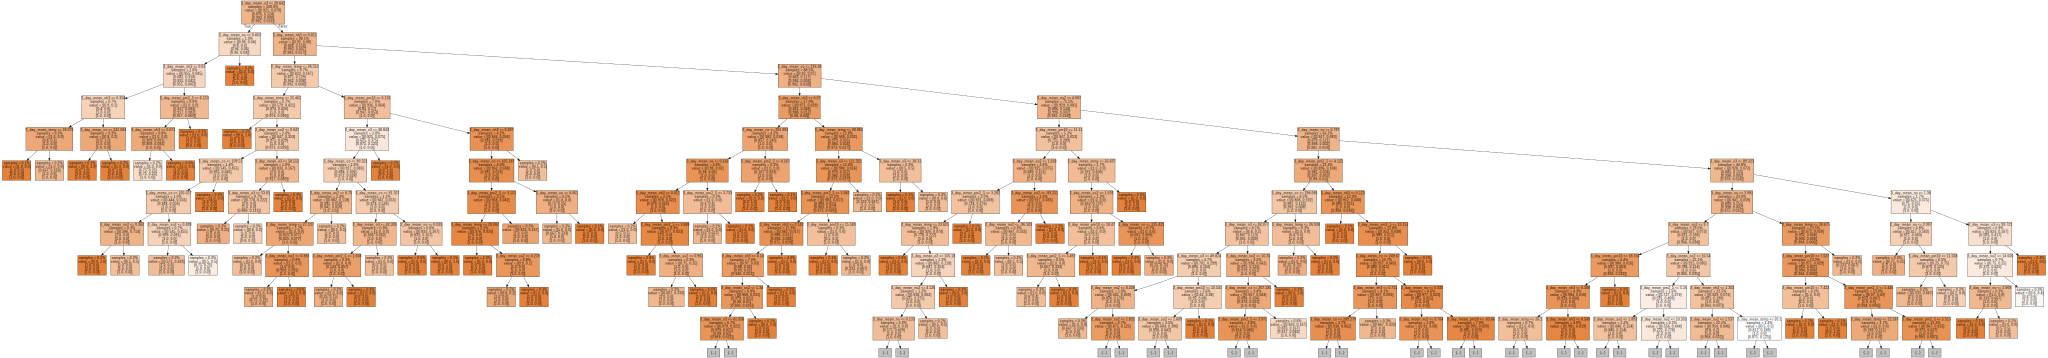

'envvs_vitals_rf_v2_model.png'

In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

tree = rfv2.estimators_[0]
dot_data = export_graphviz(tree,
                            feature_names=X.columns,
                            filled=True,
                            max_depth=10,
                            impurity=False,
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)
graph.render(f'envvs_vitals_rf_v2_model', format='png')


## Charting Relationships

In [ ]:
# Relationship between the PM2.5 and SUM of criticallity
# imputing with zero for missing recording
to_chart_df = pd.merge(all_3_days_df, critical_values_df.fillna(0), on='time', how='right')

from datetime import datetime
from collections import OrderedDict
daily_group = OrderedDict()
want_columns = ["temp", "respiratory_rate", "heart_rate", "oxygen_saturation"]
for _, row in to_chart_df.iterrows():
  tx = str(row["time"].date())
  values = daily_group.get(tx, [])
  values.append([row[c] for c in want_columns])
  daily_group[tx] = values


import numpy as np
results = []
combined_results = []
for time, grouped_values in daily_group.items():
  flattened = np.sum(np.array(grouped_values), axis=0) # column-wise summation
  results.append([time, *flattened])
  combined_results.append([time, np.sum(flattened)]) # totals all the critical points

daily_criticality_df = pd.DataFrame(columns=["time", *want_columns], data=(results))
daily_combined_criticality_df = pd.DataFrame(columns=['time', "criticality_points"], data=combined_results)
daily_combined_criticality_df

,time,criticality_points
0,2021-10-01,1.0
1,2021-09-03,0.0
2,2023-05-24,2.0
3,2023-07-31,3.0
4,2022-03-07,2.0
...,...,...
1138,2022-05-24,0.0
1139,2022-12-09,0.0
1140,2022-10-03,4.0
1141,2022-11-10,1.0


## Heatmap [or Correlation Matrix] - Environmental factors vs Vitals (Resp Rate, O2 Sat)

In [ ]:
# Heatmap (Correlation : Spearmans) - Environmental factors vs Vitals (Resp Rate, O2 Sat)
patient_vitals_daily_df = pd.read_csv(f"{CSV_DUMPS_DIR}/patients_vital_sign_daily_average.csv")


# interested_vitals = ['respiratory_rate_value']#, 'oxygen_saturation_value']#,'temp_value']
interested_vitals = ['respiratory_rate_value', 'oxygen_saturation_value', 'heart_rate_value', 'temp_value']
vitals_to_chart_df = patient_vitals_daily_df.loc[:, ['date', *interested_vitals]]
vitals_to_chart_df = vitals_to_chart_df.dropna()
vitals_to_chart_df['time'] = vitals_to_chart_df['date']
vitals_to_chart_df['time']= pd.to_datetime(vitals_to_chart_df['time'])
del vitals_to_chart_df['date']

to_chart_env_vitals_df = pd.merge(
    vitals_to_chart_df, daily_env_df, on='time', how='left'
)
del to_chart_env_vitals_df['time']
to_chart_env_vitals_df

,respiratory_rate_value,oxygen_saturation_value,heart_rate_value,temp_value,mean_co,mean_no,mean_no2,mean_o3,mean_so2,mean_pm2_5,mean_pm10,mean_nh3
0,14.0,99.0,60.0,97.2,269.950417,0.143333,5.928333,79.751667,1.057083,3.859167,7.983750,0.190417
1,18.0,99.0,73.0,97.1,228.225000,0.070417,1.615000,73.880833,0.817500,6.117500,20.915417,0.049167
2,16.0,99.0,66.0,98.1,253.399583,0.243750,7.053333,92.148333,1.268750,2.839167,8.204583,0.370833
3,18.0,98.0,65.0,97.0,488.440833,25.570833,28.382917,23.077500,4.694167,9.105417,11.783333,1.604583
4,17.0,99.0,58.0,97.9,269.950417,0.143333,5.928333,79.751667,1.057083,3.859167,7.983750,0.190417
...,...,...,...,...,...,...,...,...,...,...,...,...
2366,16.0,100.0,67.0,97.9,314.872500,3.470000,22.051667,36.426250,2.992917,7.935417,12.690833,0.806667
2367,15.0,98.0,67.0,98.6,220.645833,0.529167,7.711667,75.053333,1.135417,5.030000,12.387917,0.327083
2368,16.0,98.0,74.0,97.3,236.849167,0.120417,4.512500,111.342917,2.034583,8.904583,20.190000,0.484583
2369,17.0,97.0,100.0,98.3,305.414583,1.892500,24.187500,52.679583,2.474167,8.101250,15.866667,0.802500


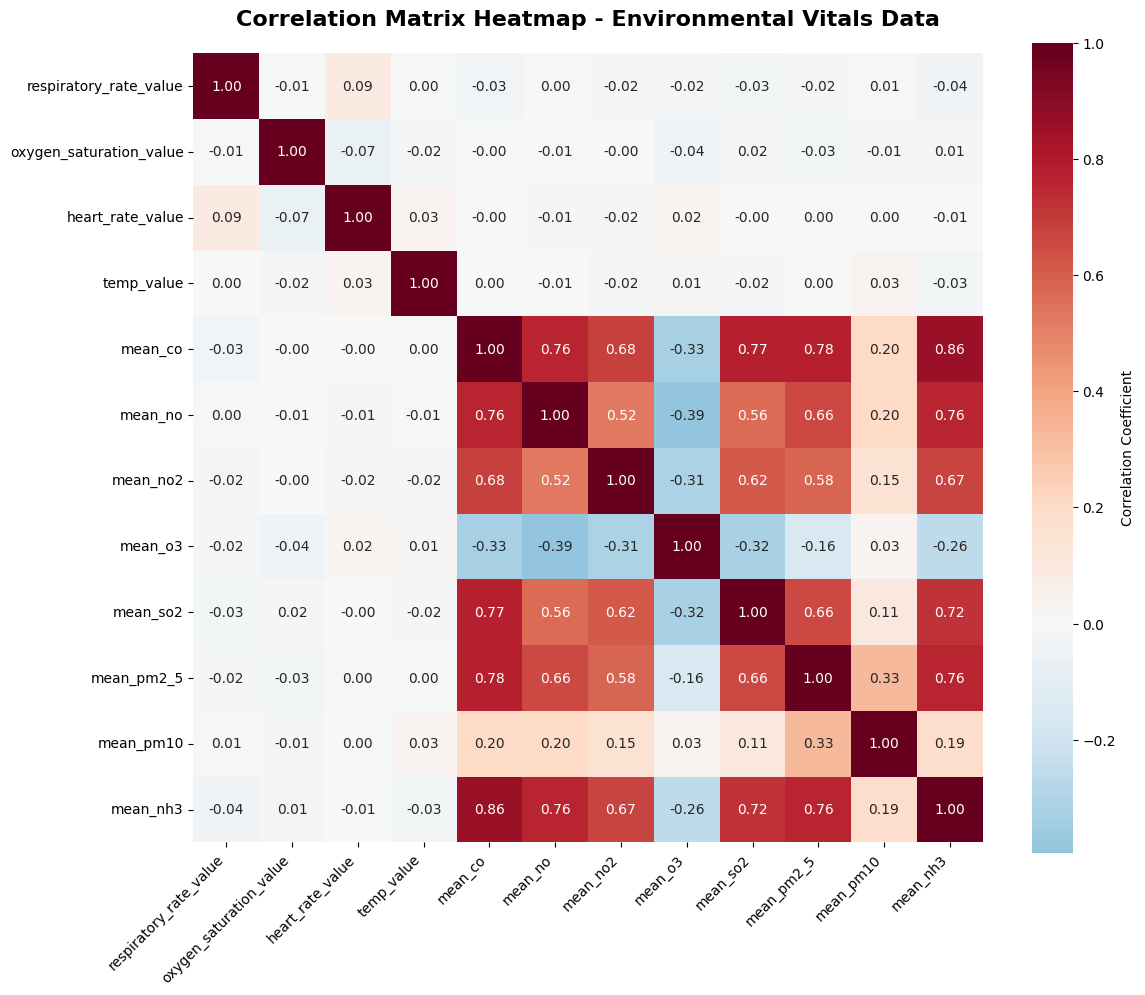

In [ ]:
correlation_matrix = to_chart_env_vitals_df.corr()

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix,
                      annot=True,  # Show correlation values
                      cmap='RdBu_r',  # Color scheme (red-blue reversed)
                      center=0,  # Center colormap at 0
                      square=True,  # Make cells square
                      fmt='.2f',  # Format to 2 decimal places
                      cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix Heatmap - Environmental Vitals Data',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


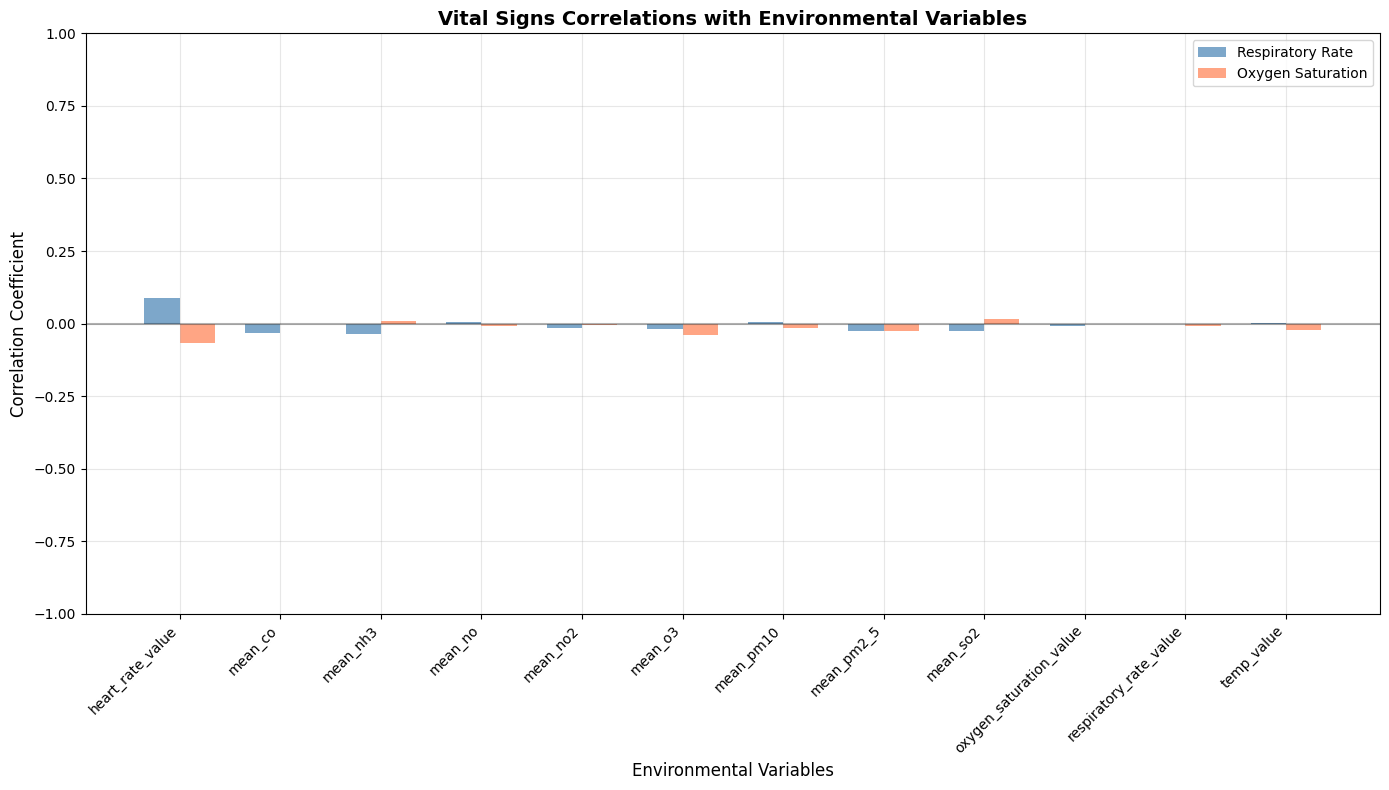

Combined Correlations:
                         Respiratory Rate  Oxygen Saturation
heart_rate_value                    0.087             -0.065
mean_co                            -0.032             -0.002
mean_nh3                           -0.035              0.009
mean_no                             0.004             -0.009
mean_no2                           -0.017             -0.004
mean_o3                            -0.018             -0.040
mean_pm10                           0.007             -0.013
mean_pm2_5                         -0.024             -0.025
mean_so2                           -0.027              0.017
oxygen_saturation_value            -0.009                NaN
respiratory_rate_value                NaN             -0.009
temp_value                          0.001             -0.023


In [ ]:

# Calculate correlations with the two vital signs
respiratory_corr = to_chart_env_vitals_df.corr()['respiratory_rate_value'].drop('respiratory_rate_value')
oxygen_corr = to_chart_env_vitals_df.corr()['oxygen_saturation_value'].drop('oxygen_saturation_value')

# Create a comparison DataFrame
correlation_comparison = pd.DataFrame({
    'Respiratory Rate': respiratory_corr,
    'Oxygen Saturation': oxygen_corr
})

# Combined bar chart
plt.figure(figsize=(14, 8))
x = np.arange(len(correlation_comparison.index))
width = 0.35

plt.bar(x - width/2, correlation_comparison['Respiratory Rate'],
        width, label='Respiratory Rate', color='steelblue', alpha=0.7)
plt.bar(x + width/2, correlation_comparison['Oxygen Saturation'],
        width, label='Oxygen Saturation', color='coral', alpha=0.7)

plt.xlabel('Environmental Variables', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Vital Signs Correlations with Environmental Variables',
          fontsize=14, fontweight='bold')
plt.xticks(x, correlation_comparison.index, rotation=45, ha='right')


# Set Y-axis limits to [-1, 1]
plt.ylim(-1, 1)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the correlation values
print("Combined Correlations:")
print("=" * 50)
print(correlation_comparison.round(3))

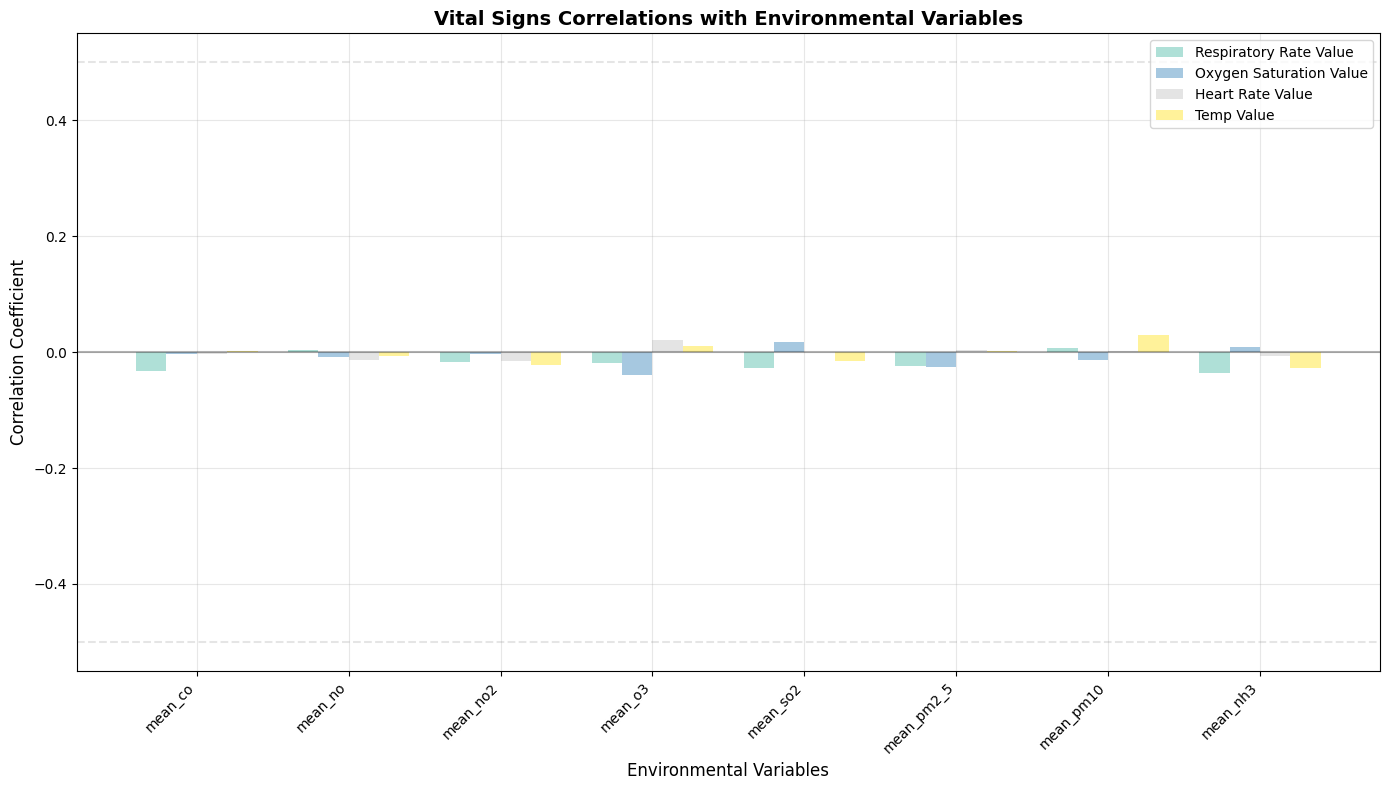

Dynamic Correlations:
            Respiratory Rate Value  Oxygen Saturation Value  Heart Rate Value  \
mean_co                     -0.032                   -0.002            -0.003   
mean_no                      0.004                   -0.009            -0.014   
mean_no2                    -0.017                   -0.004            -0.016   
mean_o3                     -0.018                   -0.040             0.021   
mean_so2                    -0.027                    0.017            -0.000   
mean_pm2_5                  -0.024                   -0.025             0.004   
mean_pm10                    0.007                   -0.013             0.002   
mean_nh3                    -0.035                    0.009            -0.007   

            Temp Value  
mean_co          0.001  
mean_no         -0.006  
mean_no2        -0.022  
mean_o3          0.010  
mean_so2        -0.015  
mean_pm2_5       0.001  
mean_pm10        0.030  
mean_nh3        -0.028  


In [ ]:

def create_dynamic_correlation_chart(df, vital_signs_list):
    """
    Create a dynamic correlation chart for any list of vital signs
    """
    # Filter vital signs that actually exist in the dataframe
    available_vitals = [vital for vital in vital_signs_list if vital in df.columns]

    if not available_vitals:
        print("No valid vital signs found in the dataframe!")
        return

    # Get environmental variables (non-vital columns)
    env_variables = [col for col in df.columns if col not in vital_signs_list]

    # Calculate correlations for each vital sign
    correlation_data = {}
    for vital in available_vitals:
        vital_corr = df.corr()[vital]
        # Only keep correlations with environmental variables
        correlation_data[vital.replace('_', ' ').title()] = vital_corr[env_variables]

    # Create comparison DataFrame
    correlation_comparison = pd.DataFrame(correlation_data)

    # Create the combined bar chart
    num_vitals = len(available_vitals)
    colors = plt.cm.Set3(np.linspace(0, 1, num_vitals))  # Dynamic color selection

    plt.figure(figsize=(max(14, len(env_variables) * 1.2), 8))
    x = np.arange(len(env_variables))
    width = 0.8 / num_vitals  # Adjust bar width based on number of vitals

    for i, (vital_name, color) in enumerate(zip(correlation_comparison.columns, colors)):
        offset = (i - (num_vitals - 1) / 2) * width
        plt.bar(x + offset, correlation_comparison[vital_name],
                width, label=vital_name, color=color, alpha=0.7)

    plt.xlabel('Environmental Variables', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.title(f'Vital Signs Correlations with Environmental Variables',
              fontsize=14, fontweight='bold')
    plt.xticks(x, env_variables, rotation=45, ha='right')

    # Set Y-axis limits to [-1, 1]
    # plt.ylim(-1, 1)

    # Add horizontal lines for reference
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.2)
    plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.2)

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print the correlation values
    print("Dynamic Correlations:")
    print("=" * 60)
    print(correlation_comparison.round(3))

    return correlation_comparison

# Use the dynamic function
correlations = create_dynamic_correlation_chart(to_chart_env_vitals_df, interested_vitals)

### SUM Total Criticality vs PM2.5 (3-Day Mean) over Time

In [ ]:
# SUM Total Criticality vs PM2.5
all_3_days_df.loc[:, ['time', '3_day_mean_pm2_5']]

,time,mean_pm2_5
0,2020-11-25,5.020870
1,2020-11-26,4.555417
2,2020-11-27,6.814167
3,2020-11-28,8.793333
4,2020-11-29,8.015833
...,...,...
1724,2025-08-23,7.614167
1725,2025-08-24,4.748750
1726,2025-08-25,2.122500
1727,2025-08-26,1.488750


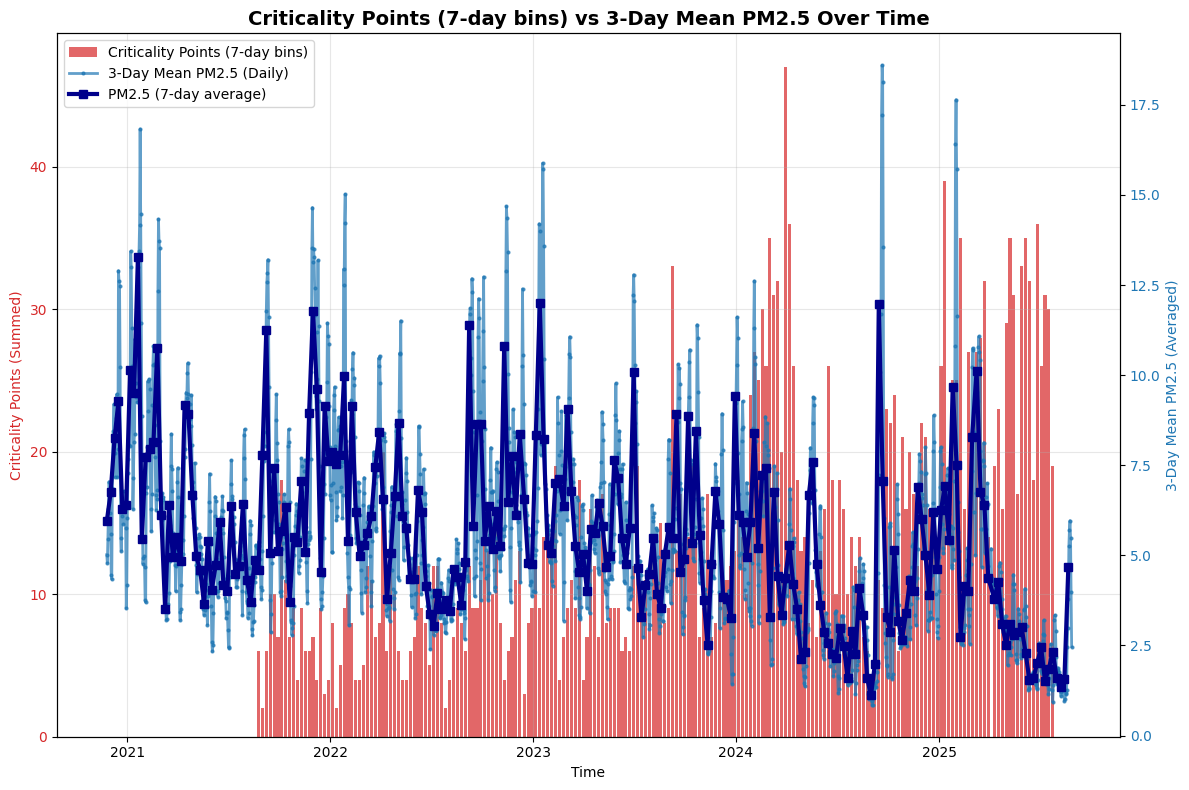

Original data points: 1729
Binned data points: 247
Each bin represents 7 days


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Ensure time columns are datetime
daily_combined_criticality_df['time'] = pd.to_datetime(daily_combined_criticality_df['time'])
all_3_days_df['time'] = pd.to_datetime(all_3_days_df['time'])

# Create a complete date range from the earliest to latest date across both dataframes
start_date = min(daily_combined_criticality_df['time'].min(), all_3_days_df['time'].min())
end_date = max(daily_combined_criticality_df['time'].max(), all_3_days_df['time'].max())
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a complete dataframe with all dates
complete_df = pd.DataFrame({'time': date_range})

# Merge with criticality data, filling missing values with 0
complete_df = complete_df.merge(daily_combined_criticality_df, on='time', how='left')
complete_df['criticality_points'] = complete_df['criticality_points'].fillna(0)

# Merge with environmental data
merged_df = complete_df.merge(all_3_days_df, on='time', how='inner')

# Create bins (e.g., weekly bins - adjust bin_days as needed)
bin_days = 7  # You can change this to 14 for bi-weekly, 30 for monthly, etc.

# Create binned data for criticality points
merged_df = merged_df.sort_values('time')
merged_df['bin_group'] = (merged_df.index // bin_days)

# Aggregate data by bins
binned_data = merged_df.groupby('bin_group').agg({
    'time': 'first',  # Use first date of the bin as representative
    'criticality_points': 'sum',  # Sum criticality points in the bin
    '3_day_mean_pm2_5': 'mean'  # Average PM2.5 over the bin
}).reset_index()

# Create the combined chart
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot criticality points as thicker bars
color1 = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Criticality Points (Summed)', color=color1)
bar_width = bin_days * 0.8  # Make bars slightly smaller than bin width
ax1.bar(binned_data['time'], binned_data['criticality_points'],
        color=color1, alpha=0.7, label=f'Criticality Points ({bin_days}-day bins)',
        width=bar_width)
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis for PM2.5 line
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('3-Day Mean PM2.5 (Averaged)', color=color2)
ax2.plot(merged_df['time'], merged_df['3_day_mean_pm2_5'], color=color2,
         label='3-Day Mean PM2.5 (Daily)', linewidth=2, marker='o', markersize=2, alpha=0.7)
# Also plot binned PM2.5 for comparison
ax2.plot(binned_data['time'], binned_data['3_day_mean_pm2_5'], color='darkblue',
         label=f'PM2.5 ({bin_days}-day average)', linewidth=3, marker='s', markersize=6)
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and grid
plt.title(f'Criticality Points ({bin_days}-day bins) vs 3-Day Mean PM2.5 Over Time',
          fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Print some info about the binning
print(f"Original data points: {len(merged_df)}")
print(f"Binned data points: {len(binned_data)}")
print(f"Each bin represents {bin_days} days")

## STARTING HERE FOR MODEL CREATION


In [ ]:
# Data Processing
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier

data_df = pd.read_csv(os.path.join(DATA_DIR, "model_ready_data/interested_critical_data.csv"))

# marking columns as categorical
for q, v in transform_response_buckets.items():
  if v["type"] == "options":
    data_df[q] = data_df[q].astype("category")


env_df = pd.read_csv(os.path.join(ENVIRON_DIR, "env_aqi_daily.csv"))

combined_df = pd.merge(
    data_df,
    env_df.loc[:, ['time', 'mean_pm2_5']],
    on='time',
    how='left')

combined_df

,time,mean_temp,are there any guns present in your home?,are there any smokers in your house?,are you a caregiver?,are you able to care for yourself independently?,are you blind or do you have difficulty seeing?,are you currently in school?,are you currently sexually active with anyone who has traveled (within the last 12 weeks) to a zika-affected area?,are you deaf or do you have serious difficulty hearing?,...,what is the highest grade or level of school you have completed or the highest degree you have received?,what is your code status?,what is your exercise level?,what is your pregnancy status?,what is your reason for having no contraceptive method at end of this visit?,what is your reason for having no contraceptive method at start of this visit?,what is your relationship status?,what was the date of your most recent tobacco screening?,critical_score,mean_pm2_5
0,2025-07-28,29.6,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.668333
1,2023-12-27,20.2,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.781250
2,2024-01-03,17.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.979583
3,2024-01-16,23.9,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4.159583
4,2024-01-17,20.4,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4.980833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2022-12-13,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.782500
1391,2023-01-04,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.946250
1392,2023-01-26,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.332917
1393,2023-05-30,25.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.380417


In [ ]:
X = combined_df.drop(["critical_score", "time"], axis=1)
y = combined_df["critical_score"]

rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

In [ ]:
# REFERENCES:
# - https://www.geeksforgeeks.org/machine-learning/feature-selection-using-random-forest/
# - https://stats.stackexchange.com/questions/201893/how-to-include-an-interaction-term-in-a-random-forest-model
# - https://pmc.ncbi.nlm.nih.gov/articles/PMC3912194/

In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint


data_df = pd.read_csv(os.path.join(DATA_DIR, "model_ready_data/interested_critical_data.csv"))
env_df = pd.read_csv(os.path.join(ENVIRON_DIR, "env_aqi_daily.csv"))

# marking columns as categorical
for q, v in transform_response_buckets.items():
  if v["type"] == "options":
    data_df[q] = data_df[q].astype("category")

combined_df = pd.merge(data_df, env_df.loc[:, ['time', 'mean_pm2_5']], on='time', how='left')

data_df = combined_df
X = data_df.drop(["critical_score", "time"], axis=1)
y = data_df["critical_score"]

rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

In [ ]:
# # GridSearchCV
# from sklearn.metrics import accuracy_score, mean_squared_error
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 10, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False]
# }


# rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',  # 'f1', 'precision', or 'recall'
#     # -1 for all cores
#     n_jobs=-1,
#     verbose= 1
# )
# grid_search.fit(X_train, y_train)

# print(f"")
# print(f"Best params: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


# best_rf = grid_search.best_estimator_

# y_pred = best_rf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy score: {accuracy}")

In [ ]:
# RandomizedSearchCV (Grid search takes too long ...!!!!! Leaving for posterity sake)
# Ideally we do randomized search, then gridsearch on the parameter space that random search found
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Split the data into training and test sets
# For feature importances, we actually dont need to split ... we do need to split though for validation.
# Counter arguements: https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after
# Counter counter argumenent: Our data is CLEARLY not uniform or i.i.d. Doesnt make sense to risk having all of our respiratory data (300 records) lumped into the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'max_samples': uniform(0.5, 0.5)
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to attempt - higher is better ? more precision?
    cv=5,
    # scoring='accuracy', # scoring should not matter so much in feature selection (?)
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# NOTES
# n_iter = 100 - acuracy is 0.77 and f1 score is 0.87
# n_iter = 200 - acuracy is 0.76 and f1 score is 0.86
# probably misconseption ... since its random search space, its likely that there will be some variation between runs.
# The feature importances dont change (almost at all) between all the different configurations ...

random_search.fit(X_train, y_train)

print(f"")
print(f"Best params: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")


best_rf_rand = random_search.best_estimator_
rf = best_rf_rand

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py", line 431, in fit
    raise ValueError(
ValueError:


Best params: {'bootstrap': True, 'max_depth': 5, 'max_features': 0.3, 'max_samples': np.float64(0.6205127330130058), 'min_samples_leaf': 7, 'min_samples_split': 13, 'n_estimators': 313}
Best cross-validation score: 0.7518


In [ ]:
y_pred = best_rf_rand.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.7670250896057348


In [ ]:
from sklearn.metrics import classification_report
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

feature_importance = best_rf_rand.feature_importances_
top_features = np.argsort(feature_importance)[-10:][::-1] # WTF python?
print(f"Top 10 most important features: {top_features}")
print(f"importance scores: {feature_importance[top_features]}")



Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       214
           1       0.00      0.00      0.00        65

    accuracy                           0.77       279
   macro avg       0.38      0.50      0.43       279
weighted avg       0.59      0.77      0.67       279

Top 10 most important features: [ 0 86 62 65 38 52 84 13 41 24]
importance scores: [0.23837898 0.20800941 0.1146646  0.11007136 0.05976237 0.0582199
 0.04200625 0.03717138 0.01871199 0.01702391]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# important features ✅
importances = best_rf_rand.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature mean_temp (0.2383789849543264)
2. feature mean_pm2_5 (0.20800941196606)
3. feature how many times per week do you consume alcohol? (0.11466460272813718)
4. feature how much tobacco do you smoke? (0.11007135653974537)
5. feature do you use any illicit or recreational drugs? (0.0597623689945207)
6. feature have you ever been counseled for unhealthy alcohol use? (0.05821990216287892)
7. feature what is your relationship status? (0.042006245606514225)
8. feature are you sexually active? (0.037171382510983536)
9. feature do you use protection during sex? (0.018711988517002117)
10. feature do you have any dietary restrictions? (0.017023908040398727)
11. feature what is the highest grade or level of school you have completed or the highest degree you have received? (0.014713102690973909)
12. feature are you blind or do you have difficulty seeing? (0.011760855878571449)
13. feature are you deaf or do you have serious difficulty hearing? (0.010469290400377702)
14. fe

In [ ]:
# HEREHERE
from itertools import combinations

feature_names = X.columns

# Simple heuristic: features that often split together
def get_tree_interactions(rf_model, feature_names):
    n_features = len(feature_names)
    interaction_count = np.zeros((n_features, n_features))

    for tree in rf_model.estimators_:
        tree_structure = tree.tree_
        features_used = []

        # Get all feats used in this tree
        for node in range(tree_structure.node_count):
            if tree_structure.feature[node] >= 0:  # Not a leaf
                features_used.append(tree_structure.feature[node])

        # Count co-occurrences
        for i, j in combinations(set(features_used), 2):
            interaction_count[i, j] += 1
            interaction_count[j, i] += 1

    return interaction_count

interaction_matrix = get_tree_interactions(best_rf_rand, feature_names)
print("Feature co-occurrence in trees (rough interaction proxy):")
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        count = interaction_matrix[i, j]
        if count > 10:  # Arbitrary threshold
            print(f"  {feature_names[i]} × {feature_names[j]}: {count} trees")

print()

Feature co-occurrence in trees (rough interaction proxy):
  mean_temp × are you blind or do you have difficulty seeing?: 66.0 trees
  mean_temp × are you deaf or do you have serious difficulty hearing?: 44.0 trees
  mean_temp × are you sexually active?: 127.0 trees
  mean_temp × do you feel stressed (tense, restless, nervous, or anxious, or unable to sleep at night)?: 30.0 trees
  mean_temp × do you have any dietary restrictions?: 66.0 trees
  mean_temp × do you have difficulty concentrating, remembering or making decisions?: 12.0 trees
  mean_temp × do you have difficulty doing errands alone?: 30.0 trees
  mean_temp × do you have difficulty walking or climbing stairs?: 52.0 trees
  mean_temp × do you or have you ever used e-cigarettes or vape?: 42.0 trees
  mean_temp × do you use any illicit or recreational drugs?: 202.0 trees
  mean_temp × do you use protection during sex?: 41.0 trees
  mean_temp × have you ever been counseled for unhealthy alcohol use?: 179.0 trees
  mean_temp × hav

In [ ]:
import shap
# shap can be slow

explainer = shap.TreeExplainer(best_rf_rand)

### SHAP doesnt seem to work well with mixed data types ... needs more pre-processing. skipping for now (likely for ever. What a serious waste of an hour! Caution, do not proceed down this path until later)

shap.__version__

'0.48.0'

In [ ]:
# ✅
from sklearn.inspection import permutation_importance

# perm_importance = permutation_importance(best_rf_rand, X_test, y_test,
                                      #  n_repeats=10, random_state=42, n_jobs=-1)

perm_importance = permutation_importance(
    best_rf_rand, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

perm_ranking = np.argsort(perm_importance.importances_mean)[::-1]

print("Permutation Feature Importance:")
for i, feat_idx in enumerate(perm_ranking):
    feat_name = X.columns[feat_idx]
    importance = perm_importance.importances_mean[feat_idx]
    std = perm_importance.importances_std[feat_idx]
    print(f"{i+1:2d}. {feat_name:12}: {importance:.4f} ± {std:.4f}")
print()

Permutation Feature Importance:
 1. mean_pm2_5  : 0.0000 ± 0.0000
 2. what was the date of your most recent tobacco screening?: 0.0000 ± 0.0000
 3. what is your relationship status?: 0.0000 ± 0.0000
 4. what is your reason for having no contraceptive method at start of this visit?: 0.0000 ± 0.0000
 5. what is your reason for having no contraceptive method at end of this visit?: 0.0000 ± 0.0000
 6. what is your pregnancy status?: 0.0000 ± 0.0000
 7. what is your exercise level?: 0.0000 ± 0.0000
 8. what is your code status?: 0.0000 ± 0.0000
 9. what is the highest grade or level of school you have completed or the highest degree you have received?: 0.0000 ± 0.0000
10. what grade are you in?: 0.0000 ± 0.0000
11. what contraceptive method was reported at start of this visit?: 0.0000 ± 0.0000
12. what contraceptive method was reported at end of this visit?: 0.0000 ± 0.0000
13. was your marijuana use recreational or medical?: 0.0000 ± 0.0000
14. was contraceptive counseling provided?: 0.000

In [ ]:
perm_ranking = np.argsort(perm_importance.importances_mean)[::-1][80:]

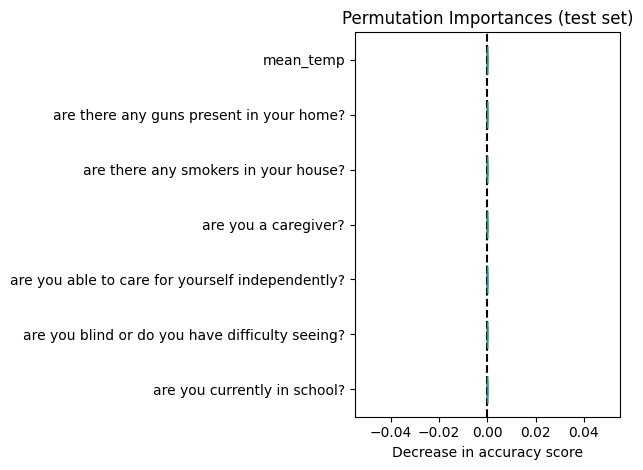

In [ ]:
# # ✅

# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
sorted_importances_idx = np.argsort(perm_importance.importances_mean)[::-1][80:]
importances = pd.DataFrame(
    perm_importance.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

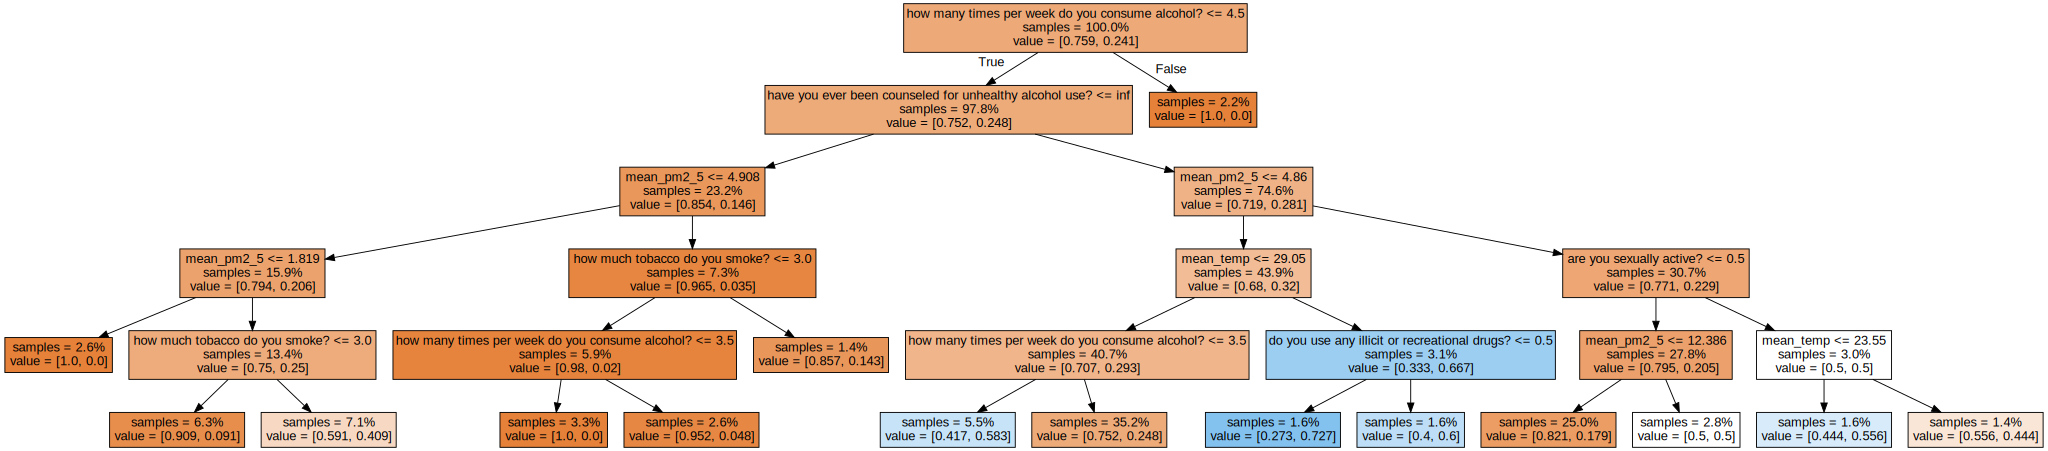

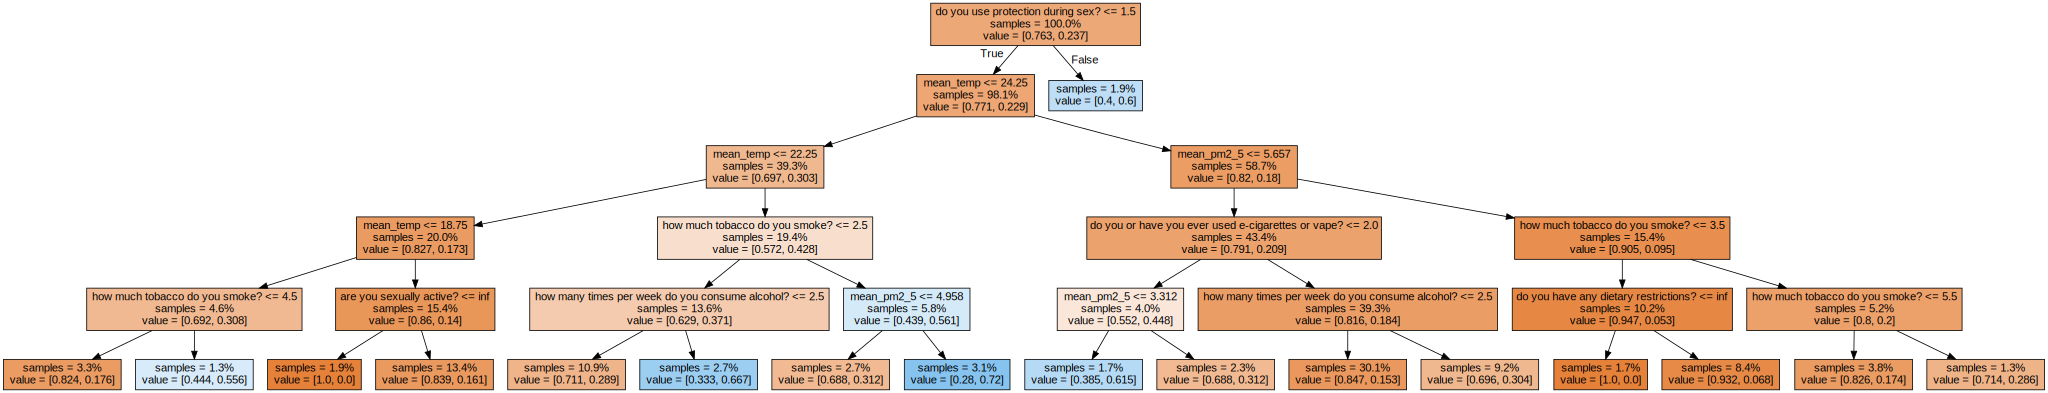

In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# create graphs
for i in range(2):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X.columns,
                               filled=True,
                               max_depth=10,  # modify this to add path
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

    graph.render(f'estimator_{i}_data', format='png', view=False)


#### >>>> Simple analysis, please feel free to ignore this <<<<<

In [ ]:
vitals_details = []
for p, r in vitals_daily_results.items():
  for k, v in r.items():
    vitals_details.append(((p, k), sorted(v.keys())))
# vitals_details[:3]

count_vital_recorded = dict()
count_interested = 0
for p, l in vitals_details:
  if p[0] not in interested_patients:
      continue

  count_interested += 1
  if 'respiratory_rate' not in l:
    continue

  for vs in l:
      count_vital_recorded[vs] = count_vital_recorded.get(vs, 0) + 1
count_vital_recorded

{'heart_rate': 349,
 'oxygen_saturation': 322,
 'respiratory_rate': 353,
 'temp': 332}

In [ ]:
len(vitals_details)

14334

In [ ]:
count_interested

1710

In [ ]:
!head -2 /content/drive/Shareddrives/RND/HERS/data/exports-20250729/DiagnosticReport.ndjson \
  | jq '.'

{
  "category": [
    {
      "coding": [
        {
          "display": "Laboratory",
          "code": "LAB",
          "system": "http://terminology.hl7.org/CodeSystem/v2-0074"
        }
      ]
    }
  ],
  "meta": {
    "lastUpdated": "2022-01-24T13:41:20.000Z"
  },
  "resourceType": "DiagnosticReport",
  "effectiveDateTime": "2022-01-24T13:41:20.000Z",
  "status": "unknown",
  "id": "a-23939.clinicalresult-2323",
  "media": [
    {
      "link": {
        "reference": "Media/a-23939.DR-doc.15058.dp.SCANPAGE.14216"
      }
    },
    {
      "link": {
        "reference": "Media/a-23939.DR-doc.15058.dp.SCANPAGE.14217"
      }
    }
  ],
  "issued": "2022-01-24T13:41:20.000Z",
  "extension": [
    {
      "url": "https://fhir.athena.io/StructureDefinition/ah-practice",
      "valueReference": {
        "reference": "Organization/a-1.Practice-23939"
      }
    },
    {
      "url": "https://fhir.athena.io/StructureDefinition/ah-chart-sharing-group",
      "valueReference": {
      

In [ ]:
#
!cat /content/drive/Shareddrives/RND/HERS/data/exports-20250729/Condition.ndjson \
  | jq -c 'select(((.meta.lastUpdated | split("-")[0] | tonumber) >= 2022)  and (.encounter == null | not))' \
  | wc -l

38314
